# MIA attacks on Length-of-Stay predictor, Logistic Regression
## Installation of Packages in Conda

To install the required packages in your conda environment, you can use the following commands:

```bash
conda install h5py
conda install pytables


In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.append(project_root)

from utils.data_processing import get_mimic_dataloaders, get_mimic_dataset
from utils.model_LR import LR, create_trained_model_and_metadata


## Train the classifier
For the LR, the data should be flatten. So set the value to True for the LR model anb False for the GRU-D

In [3]:
# Generate the dataset and dataloaders
path = os.path.join(os.getcwd(), "data/")
use_LR = True # If True, use a logistic regression model. If False, use a GRUD model.
dataset, train_indices, validation_indices, test_indices, early_stop_indices = get_mimic_dataset(path, train_frac = 0.5,
                                                                            test_frac = 0.2,
                                                                            validation_frac = 0,
                                                                            early_stop_frac = 0,
                                                                            use_LR = use_LR)

Loading dataset...
Loaded dataset from /home/fazeleh/LeakPro/examples/mia/LOS/data/LR_data/dataset.pkl


In [4]:
train_loader, validation_loader, test_loader, early_stop_loader = get_mimic_dataloaders(dataset,
                          train_indices,
                          validation_indices,
                          test_indices,
                          early_stop_indices,
                          batch_size=128)

In [5]:
n_features = dataset.x.shape[1]
print(f"Number of features: {n_features}")

model = LR(n_features)
train_acc, train_loss, test_acc, test_loss = create_trained_model_and_metadata(model,
                                                                               train_loader,
                                                                               test_loader,
                                                                               lr = 0.0001,
                                                                                weight_decay = 5.392,
                                                                               epochs=20)

Number of features: 7488


Training Progress: 100%|██████████| 20/20 [00:22<00:00,  1.10s/it]


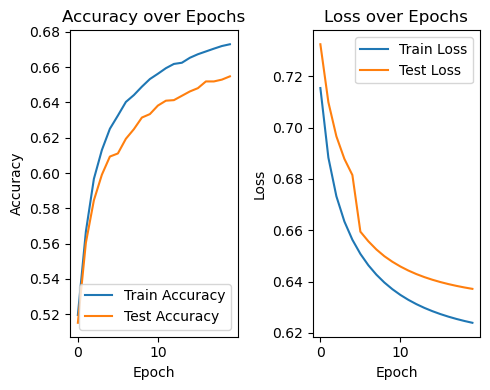

In [6]:
import matplotlib.pyplot as plt

# Plot training and test accuracy
plt.figure(figsize=(5, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label="Train Accuracy")
plt.plot(test_acc, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

# Plot training and test loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label="Train Loss")
plt.plot(test_loss, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
print("Train Accuracy: ", train_acc)
print("Test Accuracy: ", test_acc)

Train Accuracy:  [0.5196241397172847, 0.5668658087862298, 0.5966931321519486, 0.6130465814407836, 0.6250782228530721, 0.6325582760445615, 0.6402876643424339, 0.6441841366443228, 0.6489312813637105, 0.6532530898743487, 0.6562451111509445, 0.6594033558317955, 0.6618135951934977, 0.66248826650863, 0.6653140643809704, 0.6673087452320342, 0.6688878675724598, 0.6704669899128853, 0.6719630005511832, 0.6729603409767151]
Test Accuracy:  [0.5151663720607758, 0.5604915242446097, 0.584561614613784, 0.599063765061529, 0.609343370324687, 0.6110988118146595, 0.6194173834825817, 0.624857667245363, 0.631436614613784, 0.6333976466404764, 0.6382211540874682, 0.6409887404818284, 0.6413050356664156, 0.6437721409295735, 0.6462392461927313, 0.6480895751400998, 0.6519009361141607, 0.6519009361141607, 0.6529288966404764, 0.6547792255878448]


## Attack the LR model
Modify ```audit.yaml ``` file to attack LR model: 
  
  ```
  module_path: "utils/model_LR.py" 
  model_class: "LR"
  target_folder: "./target_LR"
  data_path: "./data/LR_data/dataset.pkl"
  ```


In [8]:
from mimic_LR_handler import MimicInputHandler

from leakpro import LeakPro

# Read the config file
config_path = "audit.yaml"

# Prepare leakpro object
leakpro = LeakPro(MimicInputHandler, config_path)

# Run the audit
mia_results = leakpro.run_audit(return_results=True)

2025-02-18 13:45:46,315 INFO     Target model blueprint created from GRUD in utils/model_GRUD.py.
2025-02-18 13:45:46,323 INFO     Loaded target model metadata from ./target_GRUD/model_metadata.pkl
2025-02-18 13:45:46,326 INFO     Loaded target model from ./target_GRUD
2025-02-18 13:45:47,017 INFO     Loaded population dataset from ./data/GRUD_data/dataset.pkl
2025-02-18 13:45:47,018 INFO     Loaded population dataset from ./data/GRUD_data/dataset.pkl
2025-02-18 13:45:47,111 INFO     MIA attack factory loaded.
2025-02-18 13:45:47,112 INFO     Creating shadow model handler singleton
2025-02-18 13:45:47,116 INFO     Creating distillation model handler singleton
2025-02-18 13:45:47,121 INFO     Configuring RMIA attack
2025-02-18 13:45:47,121 INFO     Added attack: rmia
2025-02-18 13:45:47,121 INFO     Preparing attack: rmia
2025-02-18 13:45:47,122 INFO     Preparing shadow models for RMIA attack
2025-02-18 13:45:47,122 INFO     Preparing attack data for training the RMIA attack
2025-02-18

<Figure size 640x480 with 0 Axes>

## Generate report

In [ ]:
# Import and initialize ReportHandler
from leakpro.reporting.report_handler import ReportHandler

# report_handler = ReportHandler()
report_handler = ReportHandler(report_dir="./leakpro_output/results")

# Save MIA resuls using report handler
for res in mia_results:
    report_handler.save_results(attack_name=res.attack_name, result_data=res, config=res.configs)

# # Create the report by compiling the latex text
report_handler.create_report()